In [1]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
from lib.utils import *
import mpld3

%load_ext autoreload
%autoreload 2

In [2]:
dir = os.getcwd()
model_dir = os.path.join(dir, 'models/')
dataset_dir = os.path.join(dir, 'datasets/')
dictionary_dir = os.path.join(dir, 'dictionaries/')
executable_dir = os.path.join(dir, 'executables/')
all_words_dir = os.path.join(dir, 'allwords/')

input_file = "soya_6_months"
input_csv = input_file + ".csv"

In [3]:
csv = pd.read_csv(os.path.join(dataset_dir, input_csv), encoding='utf-8',parse_dates=['date'])
csv = csv.set_index("date").sort_index()
temp = csv.groupby(pd.TimeGrouper(freq="1W"))
weeksList = [temp.get_group(x) for x in temp.groups]

In [5]:
from lib.utils import *
import itertools
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import OrderedDict
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from __future__ import print_function

import sys
class Logger(object):
    def __init__(self, filename="Default.log"):
        self.terminal = sys.stdout
        self.log = open(filename, "a")

    def write(self, message):
        self.terminal.write(message)
        self.log.write(message.encode("utf-8"))

    def flush(self):
        pass

sys.stdout = Logger("soya_6_month_clusters.txt")

for csv in weeksList:
    if(len(csv) <= 1):
        continue
    titles = csv["title"]
    contents = csv["contents"]
    totalvocab_stemmed = []
    totalvocab_tokenized = []

    stemmer = "lemma"
    is_english_word = load_from_dictionary("english")
    totalvocab_stemmed, totalvocab_tokenized = preprocess(contents, stemmer, is_english_word)

    #Flatten lists
    totalvocab_stemmed = list(itertools.chain.from_iterable(totalvocab_stemmed))
    totalvocab_tokenized = list(itertools.chain.from_iterable(totalvocab_tokenized))
    vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
#     text = 'there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame'
#     print(text)

    #define vectorizer parameters
    tfidf_vectorizer = TfidfVectorizer(max_df=1.0, max_features=200000,
                                     min_df=1, stop_words=stop_words,
                                     use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))
    %time tfidf_matrix = tfidf_vectorizer.fit_transform(titles) #fit the vectorizer to contents

    terms = tfidf_vectorizer.get_feature_names()
    # [ print(term) for term in terms[0:30] ]
    idf = tfidf_vectorizer.idf_
    top_idf_indices = idf.argsort()

    top_idf_values = idf[top_idf_indices]
    top_features = np.array(tfidf_vectorizer.get_feature_names())[top_idf_indices]
    
    dist = 1 - cosine_similarity(tfidf_matrix)
    

    num_clusters = 4

    km = KMeans(n_clusters=num_clusters)

    %time km.fit(tfidf_matrix)

    clusters = km.labels_.tolist()
    
    starting_date = str(csv.iloc[1].name.date())
    print("Current Starting Date: " + starting_date)
    
    articles = { 'title': titles, 'content': contents, 'cluster': clusters}
    frame = pd.DataFrame(articles , columns = [ 'title', 'cluster'])
    
    print("Top terms per cluster:")
    print()
    #sort cluster centers by proximity to centroid
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    cluster_names = {}
    for i in range(num_clusters):
        print("Cluster %d words:" % i, end='')
    #     print(vocab_frame.ix[ [term.split(' ') for term in terms] ].values.tolist()[0][0].encode('utf-8', 'ignore'))
        cluster_names[i] = []
        for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
            cluster_name = str(vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0]).encode('utf-8', 'ignore')
            cluster_names[i].append(cluster_name)
            print(' %s ' % cluster_name, end=',')
        cluster_names[i] = ' , '.join(cluster_names[i])
        print() #add whitespace
        print() #add whitespace

        print("Cluster %d titles:" % i, end='\n')
        for title in frame.loc[frame['cluster'] == i]['title'].values.tolist():
            print(' %s,' % title, end='\n')
        print() #add whitespace
        print() #add whitespace

    print(cluster_names)
    print()
    print()


In [41]:
titles = csv["title"]
contents = csv["contents"]

# tags = csv["tags"]
# categories = csv["categories"]

In [42]:
#not super pythonic, no, not at all.
#use extend so it's a big flat list of vocab=


totalvocab_stemmed = []
totalvocab_tokenized = []
from lib.utils import *
stemmer = "lemma"
is_english_word = load_from_dictionary("english")
totalvocab_stemmed, totalvocab_tokenized = preprocess(contents, stemmer, is_english_word)

#Flatten lists
totalvocab_stemmed = list(itertools.chain.from_iterable(totalvocab_stemmed))
totalvocab_tokenized = list(itertools.chain.from_iterable(totalvocab_tokenized))

In [43]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
text = 'there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame'
print(text)

there are 7790 items in vocab_frame


In [44]:
print (vocab_frame.head())
print
print
print
print

             words
today        today
events       event
lips           lip
past          past
operator  operator


<function print>

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words=stop_words,
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))
%time tfidf_matrix = tfidf_vectorizer.fit_transform(contents) #fit the vectorizer to contents

print(tfidf_matrix.shape)

CPU times: user 1.96 s, sys: 80.7 ms, total: 2.04 s
Wall time: 2.1 s
(146, 20)


In [46]:
from collections import OrderedDict
terms = tfidf_vectorizer.get_feature_names()
# [ print(term) for term in terms[0:30] ]
idf = tfidf_vectorizer.idf_
top_idf_indices = idf.argsort()

top_idf_values = idf[top_idf_indices]
top_features = np.array(tfidf_vectorizer.get_feature_names())[top_idf_indices]
# for key,value in OrderedDict(zip(top_features, top_idf_values)).iteritems():
#     print(key)


In [74]:
remove_stems(list(OrderedDict(zip(top_features, top_idf_values)).keys() ), "hubspot_marketing_tf_idf_titles_words")

In [47]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)
print
print

<function print>

In [48]:
from sklearn.cluster import KMeans

num_clusters = 4

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 76.2 ms, sys: 1.69 ms, total: 77.9 ms
Wall time: 77.4 ms


In [49]:
from sklearn.externals import joblib

#uncomment the below to save your model 
#since I've already run my model I am loading from the pickle

joblib.dump(km,  'doc_cluster.pkl')

# km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

# print(clusters)

In [50]:
articles = { 'title': titles, 'content': contents, 'cluster': clusters}
frame = pd.DataFrame(articles , columns = [ 'title', 'cluster'])

# print(frame)

In [51]:
frame['cluster'].value_counts() #number of films per cluster (clusters from 0 to 4)

1    61
0    38
2    27
3    20
Name: cluster, dtype: int64

In [52]:
# grouped = frame['rank'].groupby(frame['cluster']) #groupby cluster for aggregation purposes

# grouped.mean() #average rank (1 to 100) per cluster

In [9]:
from __future__ import print_function
print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
cluster_names = {}
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
#     print(vocab_frame.ix[ [term.split(' ') for term in terms] ].values.tolist()[0][0].encode('utf-8', 'ignore'))
    cluster_names[i] = []
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        cluster_name = vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore')
        cluster_names[i].append(cluster_name)
        print(' %s ' % cluster_name, end=',')
    cluster_names[i] = ' , '.join(cluster_names[i])
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d titles:" % i, end='\n')
    for title in frame.loc[frame['cluster'] == i]['title'].values.tolist():
        print(' %s,' % title, end='\n')
    print() #add whitespace
    print() #add whitespace

print(cluster_names)
print()
print()

NameError: name 'args' is not defined

In [82]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()
print()

In [83]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e', 5:'#86a61e',6:'#36a61e'}

#set up cluster names using a dict
# cluster_names = {0: 'Device, smartphones, camera', 
#                  1: 'Price, Storage, Specs', 
#                  2: 'Plan, offering, month', 
#                  3: 'Like, looks, new', 
#                  4: 'Camera, Android, battery'}

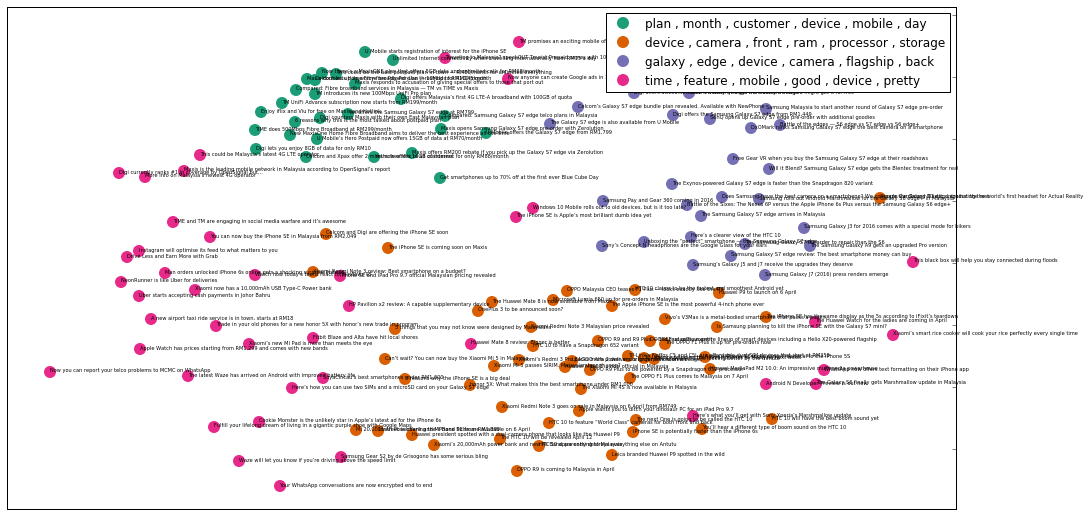

In [84]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=5)  

#uncomment the below to save the plot if need be
plt.savefig(input_file + 'clusters_small_noaxes.png', dpi=200)  
    
plt.show() #show the plot



In [203]:
#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

In [204]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }

svg.mpld3-figure {
margin-left: -200px;}
"""

# Plot 
fig, ax = plt.subplots(figsize=(14,6)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, 
                     label=cluster_names[name], mec='none', 
                     color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot

#uncomment the below to export to html
# html = mpld3.fig_to_html(fig)
# print(html)

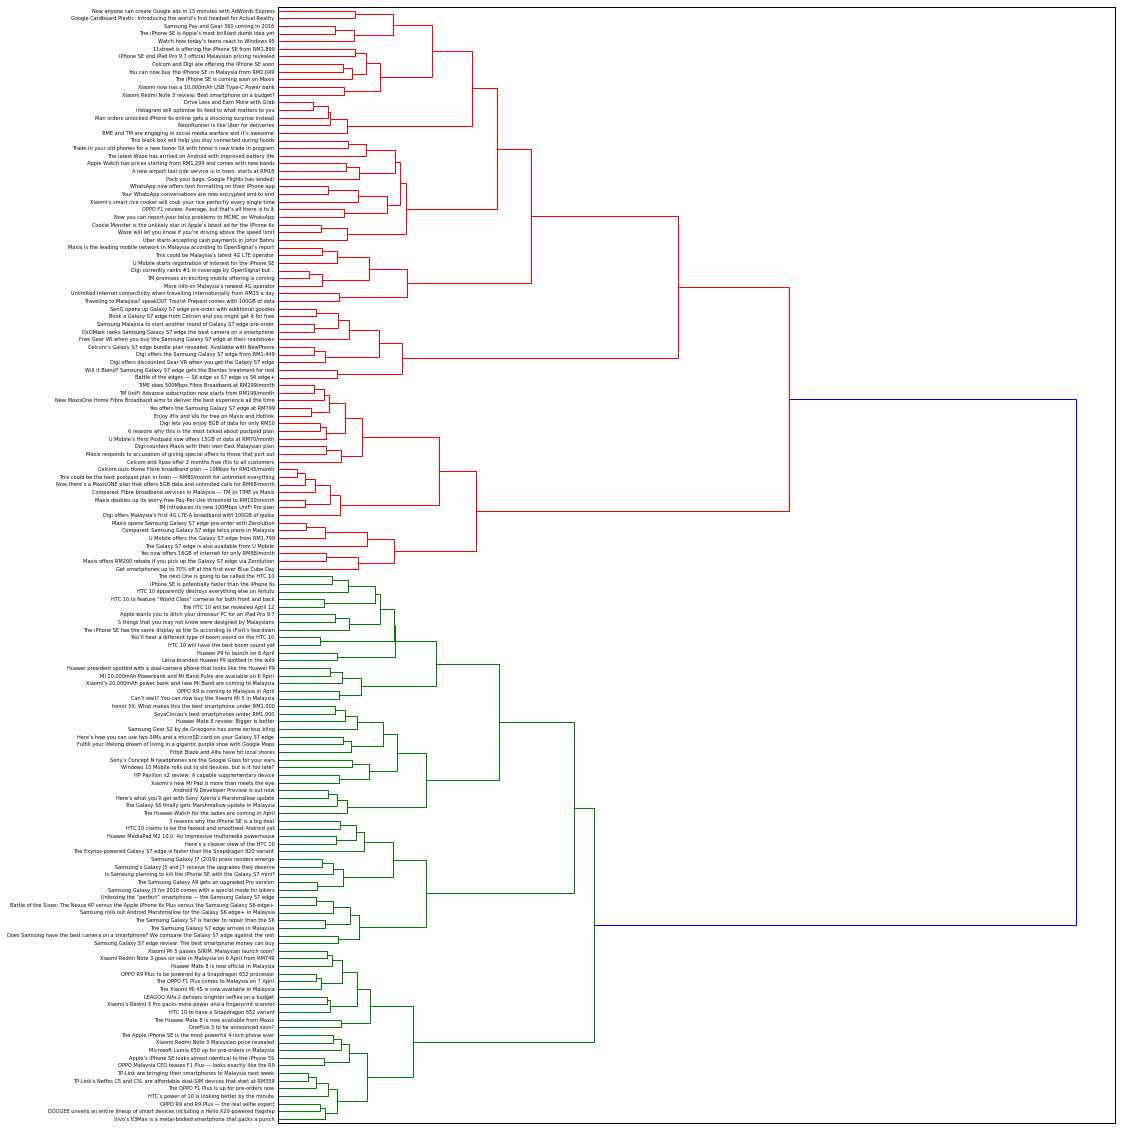

In [205]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="left", labels=titles.values.tolist());

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

# plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig( input_file + 'ward_clusters.png', dpi=200) #save figure as ward_clusters